### IMPORT

In [1]:
import pandas as pd

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option("display.max_columns",100)

In [4]:
### working with date : 
from datetime import datetime
from dateutil.relativedelta import relativedelta

### LOAD DATASET

In [5]:
### a function to load (and concatene) informations from Parc_XX.csv
def create_df_parc_data(list_num_parc,list_date_parc):
    df_parc_data = pd.DataFrame()
    for num_parc in list_num_parc:
        for date_parc in list_date_parc:
            df_parc_data = df_parc_data.append(pd.read_csv("../data/Parc%s_%s.csv"%(num_parc,date_parc),sep=";",decimal=','),ignore_index=True)
    df_parc_data["Date"] = pd.to_datetime(df_parc_data["Date"],format = "%d/%m/%Y %H:%M")
    return df_parc_data

In [6]:
list_num_parc = [1,2,3]
list_date_parc = ["2015","2016","2017"]

In [7]:
df_parc_data = create_df_parc_data(list_num_parc,list_date_parc)

In [8]:
print (df_parc_data.shape)
df_parc_data.columns

(13226400, 17)


Index(['Catégorie', 'Date', 'Eolienne', 'Etat', 'Figee', 'Fonctionnement',
       'GridBrut', 'GridOK', 'Manquante', 'P', 'Production', 'State',
       'Température génératrice', 'TurbBrut', 'TurbOK', 'Vent',
       'Vitesse génératrice'],
      dtype='object')

In [9]:
df_parc_data["Fonctionnement"].value_counts()

1    12910771
0      315629
Name: Fonctionnement, dtype: int64

##### we create the Production_mean_hour varaible : mean production per hour

In [10]:
### we create an ident for each hour "Date_hour_int"
df_parc_data["Date_hour_int"] = df_parc_data["Date"].dt.year*10**6  + df_parc_data["Date"].dt.month*10**4 +\
df_parc_data["Date"].dt.day*10**2 + df_parc_data["Date"].dt.hour
#### we create a dataframe with "production_mean_hour" value for each Eolienne*date_hour_int
df_product_mean = df_parc_data[df_parc_data["Fonctionnement"]==1].groupby(["Eolienne","Date_hour_int"])["Production"]\
                            .mean().reset_index().rename(columns={"Production":"Production_mean_hour"})

##### we add this value in the initial dataset "df_parc_data"
df_parc_data = pd.merge(df_parc_data,df_product_mean,on=["Eolienne","Date_hour_int"],how="left")

In [11]:
df_parc_data.head(3)

,Catégorie,Date,Eolienne,Etat,Figee,Fonctionnement,GridBrut,GridOK,Manquante,P,Production,State,Température génératrice,TurbBrut,TurbOK,Vent,Vitesse génératrice,Date_hour_int,Production_mean_hour
0,Fonctionnement > Correct > Rien à signaler,2015-01-01 00:00:00,Turb3,Run,0.0,1,40276.0,0.0,0.0,-1.02,52.7,3,45.0,40161.0,0.0,3.84,1281.17,2015010100,121.923333
1,Fonctionnement > Correct > Rien à signaler,2015-01-01 00:01:00,Turb3,Run,0.0,1,40276.0,0.0,0.0,-0.53,79.9,3,45.0,40161.0,0.0,4.11,1258.79,2015010100,121.923333
2,Fonctionnement > Correct > Rien à signaler,2015-01-01 00:02:00,Turb3,Run,0.0,1,40276.0,0.0,0.0,-0.61,93.9,3,45.0,40161.0,0.0,3.70,1250.21,2015010100,121.923333


#### EXAMPLE VISUALISATION

In [12]:
eolienne_C ="Turb3" # we choose one wind turbine
date_VIZ_C=datetime(2015,3,1) # we choose one date
list_col_to_create_rolling = ["Vent","Production"]

In [13]:

df_all_VIZ = df_parc_data[(df_parc_data["Fonctionnement"]==1)&(df_parc_data["Eolienne"]==eolienne_C)].copy()
### for the visualisation, we create create the 1-hour moving avarage value (rolling_60). 
df_all_VIZ[["%s_rolling_60"%x for x in list_col_to_create_rolling]] = df_all_VIZ[list_col_to_create_rolling].rolling(window=60,min_periods=1).mean()
list_col_VIZ = ["Production","Production_mean_hour","Vent"]+["%s_rolling_60"%x for x in list_col_to_create_rolling]
df_VIZ = df_all_VIZ[(df_all_VIZ["Date"]>=date_VIZ_C)&(df_all_VIZ["Date"]<date_VIZ_C+relativedelta(days=3))].set_index("Date")[list_col_VIZ]

In [14]:
df_VIZ.head(3)

,Production,Production_mean_hour,Vent,Vent_rolling_60,Production_rolling_60
Date,,,,,
2015-03-01 00:00:00,1343.87,1760.3295,9.29,10.367500,1753.598167
2015-03-01 00:01:00,1280.38,1760.3295,9.98,10.365833,1745.156500
2015-03-01 00:02:00,1752.90,1760.3295,7.40,10.306500,1745.875000


In [15]:
df_VIZ["Production_mean_hour"].fillna(method="bfill",inplace=True)

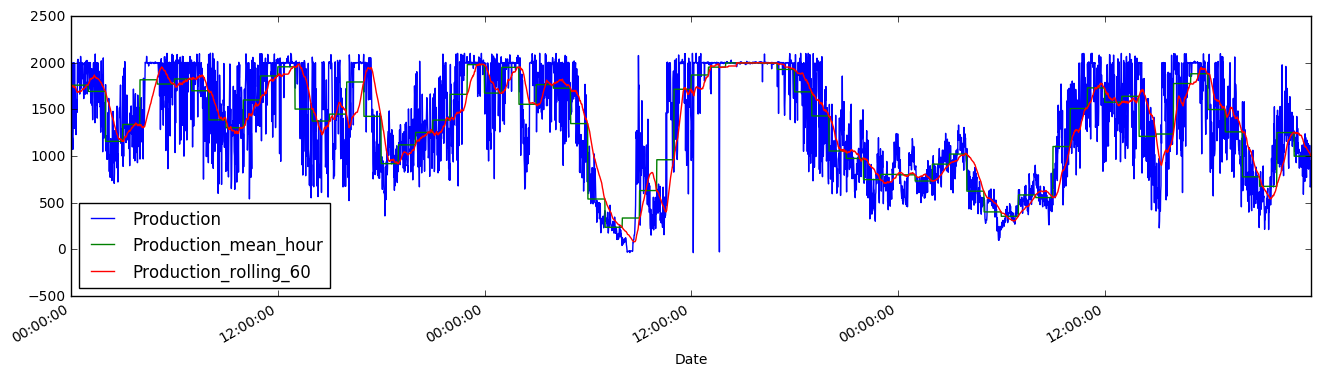

In [16]:
df_VIZ[["Production","Production_mean_hour","Production_rolling_60"]].plot(figsize=(16,4))

#### With wind

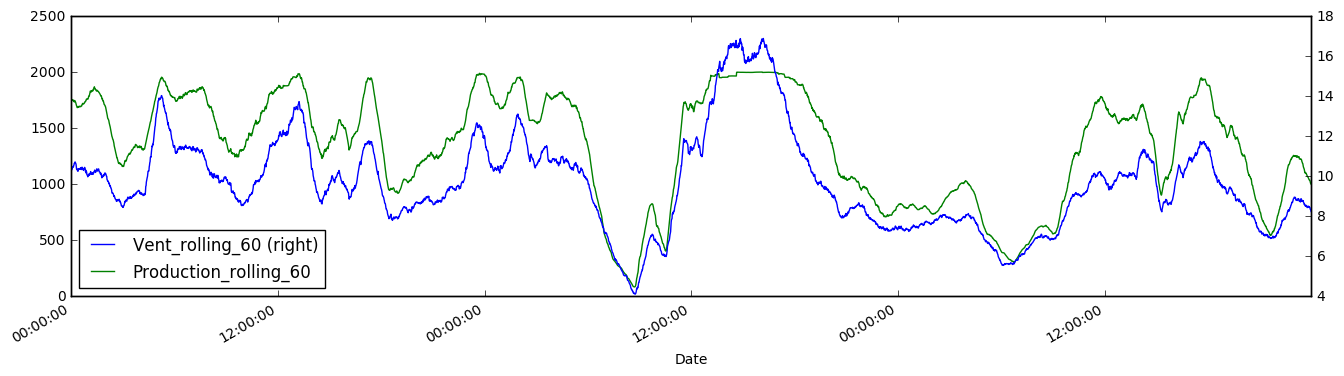

In [17]:
df_VIZ[["Vent_rolling_60","Production_rolling_60"]].plot(secondary_y='Vent_rolling_60',figsize=(16,4))

In [49]:
df_all_VIZ_h = df_all_VIZ.loc[df_all_VIZ["Date"].dt.minute == 0]

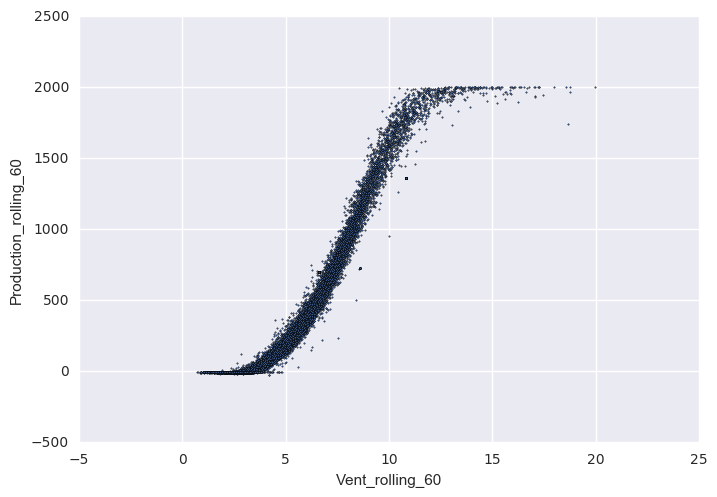

In [50]:
# relation between wind and production is cubic
# production is capped between 0 and 2000 for this turbine
# the link between wind and production is very tight. There might not be any intertia of the turbine (or it is not visible on an hourly basis) 
df_all_VIZ_h[["Vent_rolling_60","Production_rolling_60"]].plot.scatter("Vent_rolling_60", "Production_rolling_60", s=1)

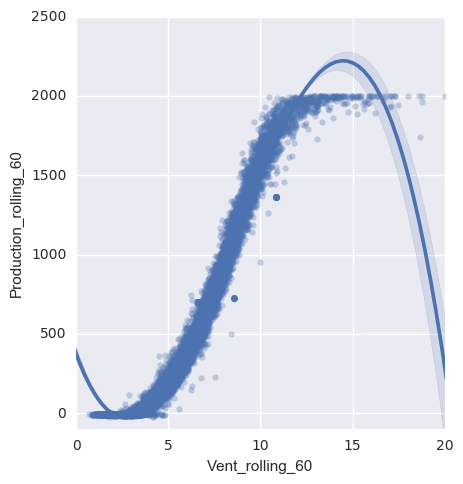

In [54]:
g = sns.lmplot("Vent_rolling_60", "Production_rolling_60", df_all_VIZ_h, order = 3, scatter_kws={'alpha':0.3})
g.set(xlim=(0, 20), ylim=(-100, 2500))

In [55]:
df_diff_VIZ = df_all_VIZ_h[["Vent_rolling_60","Production_rolling_60"]].diff()

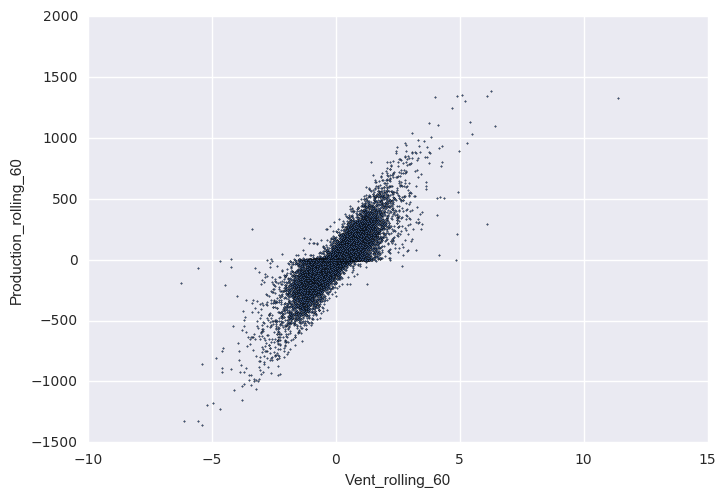

In [56]:
#2 segments, depending on wind delta < 0 or > 0
df_diff_VIZ.plot.scatter("Vent_rolling_60", "Production_rolling_60", s=1)

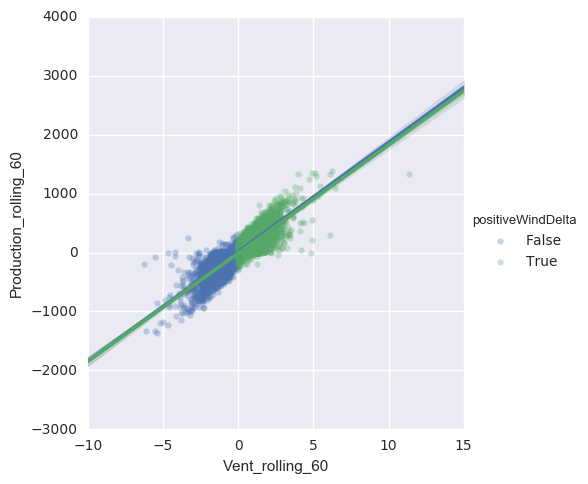

In [48]:
#Attemp to split regression if delta wind is positive or negative : not useful
df_diff_VIZ["positiveWindDelta"] = df_diff_VIZ["Vent_rolling_60"] >= 0
sns.lmplot("Vent_rolling_60", "Production_rolling_60", df_diff_VIZ, hue="positiveWindDelta", scatter_kws={'alpha':0.3})

####  WEATHER's DATASET

In [18]:
### a function to load (and concatene) informations from PrevMeteo_GrilleXX.xlsx
def create_df_meteo_from_list_grille(list_grille):
    df_meteo  = pd.DataFrame()
    for grille_C in list_grille:
        df_meteo_tmp =  pd.read_excel('../data/PrevMeteo_Grille%s.xlsx'%(grille_C),sep=';')
        df_meteo_tmp["grille"] = grille_C
        df_meteo = df_meteo.append(df_meteo_tmp,ignore_index=True)
    df_meteo["date"] = pd.to_datetime(df_meteo["date"],format = "%Y-%m-%d %H:%M:%S")
    df_meteo.rename(columns= {"date":"Date"},inplace=True)
    return df_meteo

In [19]:
## for weather's data,we can take the value of 16 different "grille" 
list_grille= range(1,17)
##for this example notebook, we will only take one "grille" (=9) 
df_meteo = create_df_meteo_from_list_grille(list_grille=[9])

In [20]:
df_meteo.shape

(58450, 36)

In [21]:
df_meteo.columns

Index(['Date', 'fc_hor', 'RS', 'CAPE', 'SP', 'CP', 'BLD', 'SSHF', 'SLHF',
       'MSL', 'BLH', 'TCC', 'U10', 'V10', 'T2', 'D2', 'SSRD', 'STRD', 'SSR',
       'STR', 'TSR', 'LCC', 'MCC', 'HCC', 'TSRC', 'SSRC', 'STRC', 'TP', 'FA',
       'U100', 'V100', 'vit_100', 'vit_10', 'dir_100', 'dir_10', 'grille'],
      dtype='object')

In [22]:
df_meteo.tail()

,Date,fc_hor,RS,CAPE,SP,CP,BLD,SSHF,SLHF,MSL,BLH,TCC,U10,V10,T2,D2,SSRD,STRD,SSR,STR,TSR,LCC,MCC,HCC,TSRC,SSRC,STRC,TP,FA,U100,V100,vit_100,vit_10,dir_100,dir_10,grille
58445,2017-04-16 20:00:00,68,26149068.0,0.000000,101590.0000,0.001052,1.216649,25.626667,-6.204444,102325.03125,473.472321,0.656982,3.630444,0.743793,8.365137,5.346338,-0.04,297.799988,0.0,-52.204445,0.0,0.390015,0.400482,0.208832,0.0,0.0,-82.862221,0.000000e+00,0.203704,6.992155,0.705566,7.027664,3.705853,264.237885,258.421661,9
58446,2017-04-16 21:00:00,69,26149068.0,0.000000,101574.1250,0.001052,2.284219,29.382223,-3.208889,102309.50000,424.312469,0.345856,3.450853,1.312599,8.043604,5.771142,0.00,291.471100,0.0,-56.346668,0.0,0.102783,0.302917,0.054443,0.0,0.0,-79.462219,0.000000e+00,0.203702,6.960267,1.711334,7.167564,3.692060,256.186584,249.174713,9
58447,2017-04-16 22:00:00,70,26149068.0,0.000000,101542.9375,0.001052,2.357309,30.035555,-3.182222,102278.21875,423.143585,0.960724,3.664190,1.628366,7.972070,5.403955,0.00,291.768890,0.0,-54.551109,0.0,0.820557,0.524689,0.636566,0.0,0.0,-76.826668,9.536743e-07,0.203700,7.269725,2.243958,7.608170,4.009722,252.846039,246.039642,9
58448,2017-04-16 23:00:00,71,26149068.0,1.261719,101503.2500,0.001052,2.289253,25.862223,-4.697778,102238.06250,439.622528,1.000000,3.670717,1.780635,8.252832,5.464746,0.00,306.364441,0.0,-42.119999,0.0,1.000000,0.881134,0.757996,0.0,0.0,-75.040001,9.536743e-07,0.203698,7.126820,2.500241,7.552666,4.079807,250.668030,244.122345,9
58449,2017-04-17 00:00:00,72,26149068.0,6.984863,101454.3750,0.001052,2.361719,11.448889,-7.035555,102187.43750,567.963623,1.000000,3.823283,2.040882,9.209375,6.013818,0.00,346.822235,0.0,-9.071111,0.0,1.000000,0.936310,0.004333,0.0,0.0,-74.235558,2.002716e-05,0.203695,6.799860,2.847061,7.371828,4.333900,247.281219,241.906540,9


In [23]:
### the aim of this challenge is to predict the Production for tomorrow. 
# so, we keep only forecast (fc_hor) between 24h and 47h (Tomorrow's Forecast)
df_meteo = df_meteo[(df_meteo["fc_hor"]>=24) & (df_meteo["fc_hor"]<=47)].copy()

### we create df_all (concatenation of train and test)
it's the dataset for the model.

In [24]:
### we keep only one row per hour (minute =0)
### we keep only one row where the wind turbine is working (Fonctionnement =1)
### we keep only usefull columns
list_col_parc_data_to_keep = ["Date","Eolienne","Production","Fonctionnement","Production_mean_hour"]
df_all = df_parc_data[(df_parc_data["Date"].dt.minute==0)&(df_parc_data["Fonctionnement"]==1)]\
[list_col_parc_data_to_keep].copy()

In [25]:
print (df_all.shape)
df_all.head(3)

(215158, 5)


,Date,Eolienne,Production,Fonctionnement,Production_mean_hour
0,2015-01-01 00:00:00,Turb3,52.7,1,121.923333
60,2015-01-01 01:00:00,Turb3,180.0,1,210.081667
120,2015-01-01 02:00:00,Turb3,156.5,1,255.016667


#### we add weather's variable

In [26]:
# for this example we will only take one variable in the weather's dataset
df_all = pd.merge(df_all, df_meteo, on="Date", how="left")

In [ ]:
# df_all.set_index('Date', inplace=True)
# df_all = pd.merge(df_all, df_meteo_transp, left_index=True, right_index=True)
# df_all.head()

#### we keep only value after 2015_1_3 to avoid missing values

In [27]:
df_all = df_all[df_all["Date"] > datetime(2015,1,3)].copy()
df_all.sort_values("Date", ascending=1, inplace=True)

#### some more data explo

In [57]:
df_all.head(1)

,Date,Eolienne,Production,Fonctionnement,Production_mean_hour,fc_hor,RS,CAPE,SP,CP,BLD,SSHF,SLHF,MSL,BLH,TCC,U10,V10,T2,D2,SSRD,STRD,SSR,STR,TSR,LCC,MCC,HCC,TSRC,SSRC,STRC,TP,FA,U100,V100,vit_100,vit_10,dir_100,dir_10,grille
49,2015-01-03 01:00:00,Turb3,194.1,1,123.66,25.0,2122496.0,0.0,102644.75,0.0,0.711319,15.173056,1.44,103438.34375,64.704727,1.0,0.792978,1.797569,2.021387,0.651025,0.0,273.57666,0.0,-43.880833,0.0,0.0,1.0,1.0,0.0,0.0,-75.732224,0.0,0.13724,3.69431,2.972359,4.741608,1.964706,231.180634,203.804153,9.0


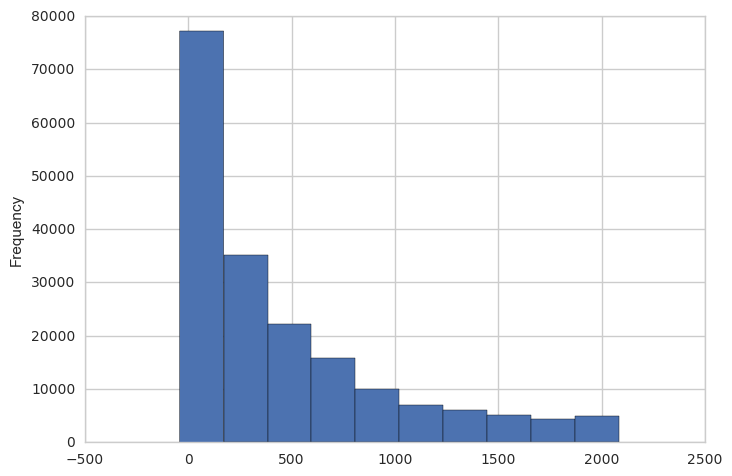

In [63]:
# Production values have a positive skewness. It might be helpful to work with log or other transformation.
df_all["Production_mean_hour"].plot.hist()

In [64]:
df_all.describe()

,Production,Fonctionnement,Production_mean_hour,fc_hor,RS,CAPE,SP,CP,BLD,SSHF,SLHF,MSL,BLH,TCC,U10,V10,T2,D2,SSRD,STRD,SSR,STR,TSR,LCC,MCC,HCC,TSRC,SSRC,STRC,TP,FA,U100,V100,vit_100,vit_10,dir_100,dir_10,grille
count,187906.000000,214620.0,187906.000000,214620.000000,2.146200e+05,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.000000,214620.0
mean,452.870827,1.0,452.080548,35.498635,9.633529e+06,20.654757,101044.164363,0.001385,3.999598,-5.607904,-47.351248,101777.006126,545.532527,0.638696,1.118800,0.629194,10.285584,6.712355,129.686087,312.446177,104.738649,-52.523722,171.347602,0.371040,0.287868,0.370877,216.862575,151.415195,-81.704002,0.000079,0.177214,1.898325,1.014505,6.555792,3.887992,200.233321,197.882024,9.0
std,548.889344,0.0,518.123459,6.934868,9.038440e+06,118.208737,939.912651,0.002354,6.280676,55.194562,68.638960,948.153975,402.776986,0.384682,3.184679,2.686453,6.111416,5.400174,203.372409,42.398189,163.653779,30.249577,240.797903,0.387039,0.367346,0.420989,291.700830,212.012822,15.897082,0.000310,0.023643,5.219733,4.488310,3.007459,1.972375,93.921102,92.602545,0.0
min,-100.600000,1.0,-42.000000,24.000000,0.000000e+00,0.000000,97080.625000,0.000000,-0.219574,-304.213348,-396.591125,97848.250000,9.858096,0.000000,-7.465865,-8.750072,-5.721594,-14.561102,-0.388611,203.466660,-0.276667,-139.968613,-0.320000,0.000000,0.000000,0.000000,-0.304722,-0.293056,-140.162506,-0.000051,0.137225,-11.103394,-12.835068,0.094867,0.047732,0.014801,0.046005,9.0
25%,32.200000,1.0,49.402083,29.000000,2.605588e+06,0.000000,100527.875000,0.000000,0.699677,-20.576389,-66.915558,101255.375000,197.016174,0.263184,-1.393397,-1.370855,5.912988,2.879968,0.000000,280.896660,0.000000,-73.153053,0.000000,0.009186,0.000000,0.000000,0.000000,0.000000,-90.173332,0.000000,0.154589,-2.161889,-2.337369,4.497897,2.342530,129.470261,129.864548,9.0
50%,241.100000,1.0,258.368417,35.000000,6.712207e+06,0.011719,101143.312500,0.000369,1.787960,9.633611,-14.956111,101869.234375,470.361359,0.817383,1.163821,0.572443,10.088037,6.856103,3.056944,315.279999,2.524444,-53.831112,8.533334,0.215454,0.066711,0.092392,10.320000,3.935555,-79.310837,0.000000,0.178248,2.314156,0.634664,6.243111,3.577574,221.501999,216.183975,9.0
75%,661.767500,1.0,671.528375,42.000000,1.458666e+07,4.125000,101666.875000,0.001821,4.579826,26.617777,-2.441667,102406.843750,830.818604,0.999176,3.266436,2.479457,14.617579,10.701319,198.946945,344.764435,162.918335,-27.866250,297.969452,0.761566,0.539215,0.883636,394.977783,265.070282,-71.031113,0.000015,0.197784,5.579457,4.357197,8.341563,5.067346,272.748718,270.209839,9.0
max,2133.500000,1.0,2083.500000,47.000000,4.663258e+07,3244.562500,103743.500000,0.031994,82.004059,138.318893,30.386667,104505.656250,2257.576416,1.000008,13.134394,12.705834,33.950096,21.558985,916.597778,419.662231,730.261108,14.100555,976.293335,1.000000,1.000000,1.000000,984.613342,730.897766,-32.866943,0.013301,0.330218,20.277729,19.616102,20.474163,13.298792,359.994690,359.969330,9.0


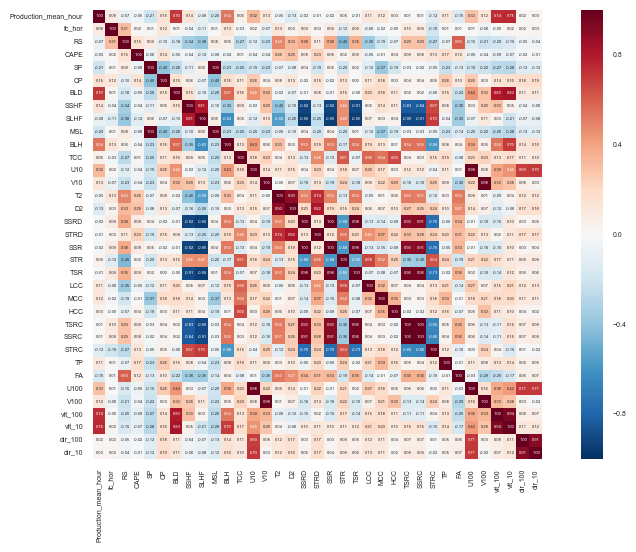

In [81]:
# heat map for all variables
# Target variable (Production_Mean_Hour) is only correlated to a few weather variables : BLD / BLH / U10 / U100 / vit_10 / vit_100
import numpy as np
cols = list(df_all.columns[4:-1])

cm = np.corrcoef(df_all.dropna()[cols].values.T)
sns.set(font_scale=0.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 3},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.savefig('./corr_mat.png', dpi=300)
plt.show()